<a href="https://colab.research.google.com/github/innysik222/Python-Libs/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2195]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2196]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [2197]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from datetime import datetime


### **Описание датасета**


*   Id - идентификационный номер квартиры
 

*   DistrictId - идентификационный номер района

* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры
района


Загружаем исходные датасеты с диска и применяем к ним функцию сжатия памяти

In [2198]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2199]:
train_df=pd.read_csv('/content/drive/MyDrive/Тренировочные данные/Project data housing Msk/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Тренировочные данные/Project data housing Msk/test.csv')

In [2200]:

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


### ***EDA***

In [2201]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [2202]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [2203]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

меняем дататайп id и DistrictId на строковый

In [2204]:
train_df['Id']=train_df['Id'].astype(str)

train_df['DistrictId']=train_df['DistrictId'].astype(str)

Построим диаграмму распределения целевой переменной

Text(0.5, 1.0, 'House price distribution')

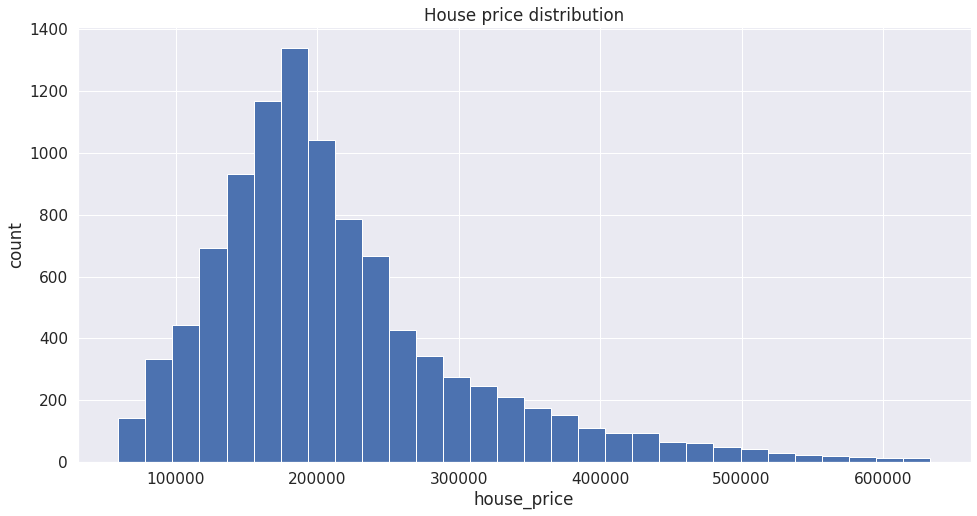

In [2205]:
plt.figure(figsize=(16,8))
train_df['Price'].hist(bins=30)
plt.xlabel('house_price')
plt.ylabel('count')
plt.title('House price distribution')


по диаграмме видно, что имеет место нормальное распределение, с минимальным количеством выбросов, если таковые ими являются

In [2206]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
print(target_mean)
print(target_median)
print(target_mode)

214138.94
192269.65625
182938.08


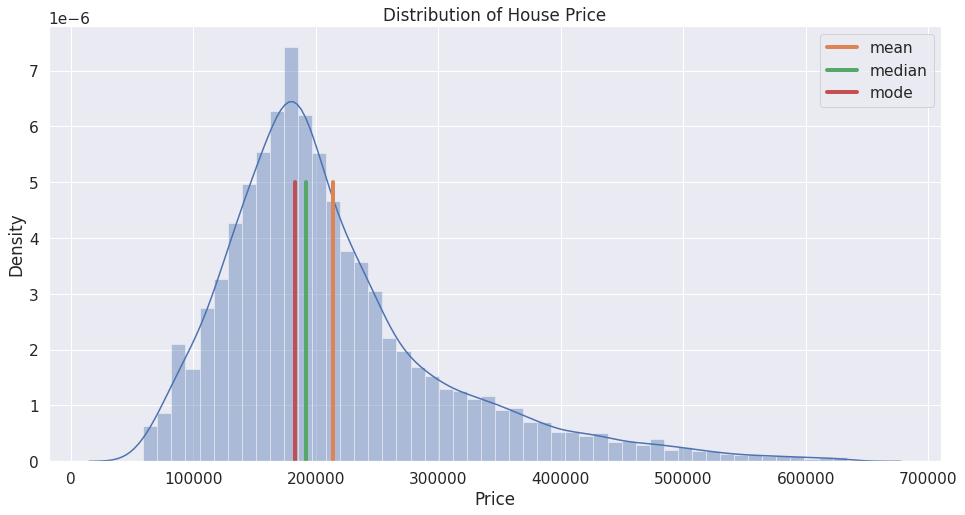

In [2207]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of House Price')
plt.legend()
plt.show()

Медиана, мода и среднее являются близкими по значению друг к другу, что еще раз доказывает отсутствие критичных выбросов в целевой переменной

Проверим количество данных в тренировочной и тестовых выборках, общую информацию по датасету

In [2208]:
train_df.shape

(10000, 20)

In [2209]:
test_df.shape

(5000, 19)

In [2210]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Сделаем отбор вещественных признаков из таблицы и построим диаграммы распределения данных признаков

In [2211]:
train_df_num_features=train_df.select_dtypes(include=['float32']or['int8']or['int16'])
train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Price
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN,305018.875000
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0,177734.546875
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0,282078.718750
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN,168106.000000
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN,343995.093750


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f281b9dced0>,
      dtype=object)

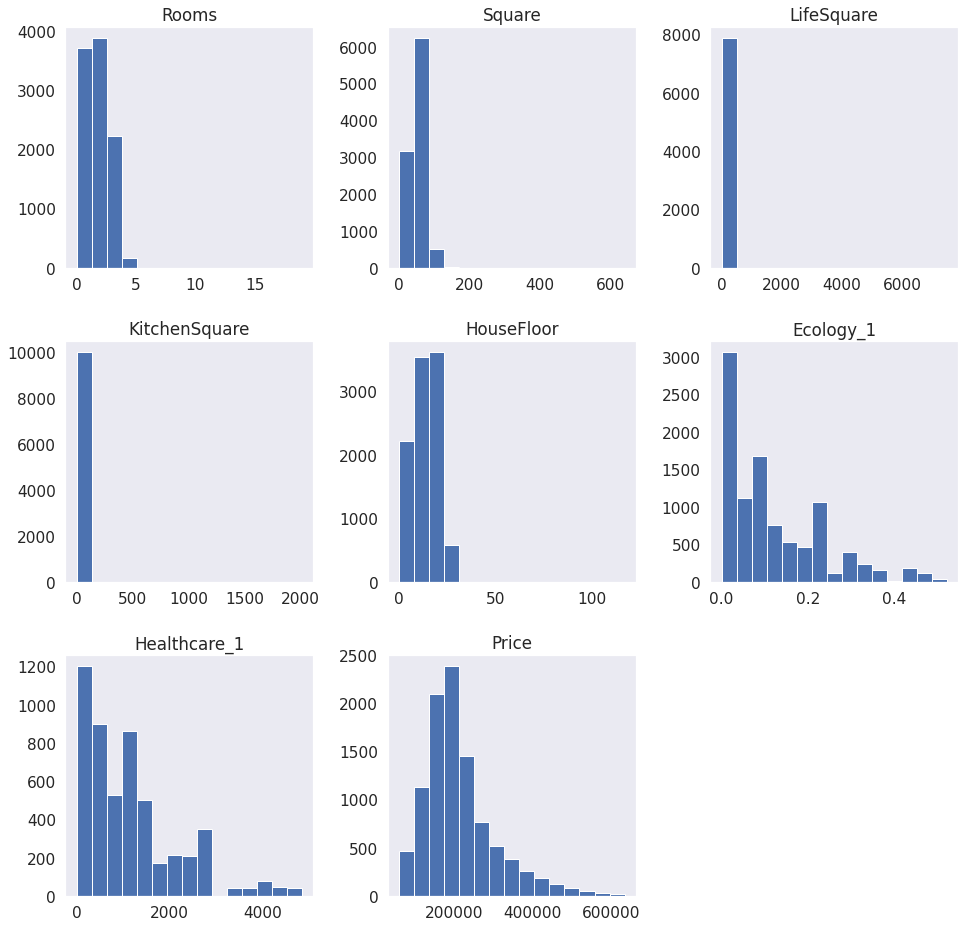

In [2212]:
train_df_num_features.hist(figsize=(16, 16), bins=15, grid=False)

In [2213]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


судя из таблицы выше, есть выбросы в признаках Square, LifeSquare, Kitchen, Rooms, HouseFloor

In [2214]:
from pylab import rcParams

rcParams["figure.figsize"] = 15, 30

Изучим в отдельности статистические показатели по вещественным признакам, в которых предполагается наличие выбросов

In [2215]:
train_df.Rooms.describe()

count    10000.000000
mean         1.890500
std          0.839522
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [2216]:
train_df.Square.describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

Среднее по Square больше медианного значения, значит присутсвует выброс справа

In [2217]:
train_df.LifeSquare.describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

Среднее по LifeSquare несколько превышает медианное значение, значит присутствует выброс справа

In [2218]:
train_df.HouseFloor.describe()

count    10000.0000
mean        12.6094
std          6.7762
min          0.0000
25%          9.0000
50%         13.0000
75%         17.0000
max        117.0000
Name: HouseFloor, dtype: float64

In [2219]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

Отдельно изучим категориальные признаки

In [2220]:
train_df_category=train_df.select_dtypes(include='category').columns.tolist
train_df_category

<bound method IndexOpsMixin.tolist of Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')>

In [2221]:
train_df['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [2222]:
pivot_category_shops2=pd.pivot_table(train_df, 
                              values=['Price'],
                              index=['Shops_2'],
                              )
pivot_category_shops2

,Price
Shops_2,
A,192339.703125
B,216099.000000


Поскольку средняя стоимость домов с категорией B признака Shops_2 выше, можно предположить, что категория B приоритетна перед категорией A

In [2223]:
train_df['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [2224]:
pivot_category_eco2=pd.pivot_table(train_df, 
                              values=['Price'],
                              index=['Ecology_2'],
                              )
pivot_category_eco2

,Price
Ecology_2,
A,193139.718750
B,214344.546875


Аналогично предыдущему пункту, для признака Ecology_2 можно предположить, что категория B приоритетна перед категорией A

In [2225]:
train_df['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [2226]:
pivot_category_eco3=pd.pivot_table(train_df, 
                              values=['Price'],
                              index=['Ecology_3'],
                              )
pivot_category_eco3

,Price
Ecology_3,
A,243179.56250
B,213317.65625


по признаку Ecology_3 можно предположить, что категория A приоритетна над категорией B

## **Заполнение пропусков**

Проверим количество пропусков в таблице

In [2227]:
total_isnull_data=train_df.isnull().sum().sort_values(ascending=False)
percent=((train_df.isnull().sum()/train_df.isnull().count())*100).sort_values(ascending=False)
missing_data=pd.concat([total_isnull_data, percent], axis=1, keys=['Total', 'Percent'])

missing_data

,Total,Percent
Healthcare_1,4798,47.98
LifeSquare,2113,21.13
Price,0,0.00
HouseYear,0,0.00
DistrictId,0,0.00
Rooms,0,0.00
Square,0,0.00
KitchenSquare,0,0.00
Floor,0,0.00
HouseFloor,0,0.00


Таблица выявила пропущенные данные в двух категориях: Healthcare_1 и LifeSquare. Причем в первой категории отсутствет почти 50% данных, что довольно много

In [2228]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [2229]:
train_df.Healthcare_1.median()

900.0

Заполним содержимое пустых ячеек признака Healthcare_1 методом интерполяции

In [2230]:
train_df.Healthcare_1.interpolate(method='values',inplace=True, limit_direction=None)
train_df.Healthcare_1.fillna(train_df['Healthcare_1'].median(), inplace=True)

In [2231]:
train_df.Healthcare_1.isna().value_counts()

False    10000
Name: Healthcare_1, dtype: int64

In [2232]:
train_df['Healthcare_1'].describe()

count    10000.000000
mean      1149.436157
std        908.692383
min          0.000000
25%        540.000000
50%        980.857117
75%       1548.000000
max       4849.000000
Name: Healthcare_1, dtype: float64

Заполним пропуски в признаке LifeSpace значениями (Space-KitchenSpace-5)

In [2233]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna())  & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square']- train_df.loc[condition, 'KitchenSquare'] - 3

In [2234]:
train_df['LifeSquare'].isna().value_counts()

False    10000
Name: LifeSquare, dtype: int64

In [2235]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

**Работа с выбросами**

In [2236]:
train_df['Rooms'].value_counts()


2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Посмотрим на объекты, где количество комнат 0 или больше 5

In [2237]:
room_outliers=train_df.loc[(train_df['Rooms']==0)|(train_df['Rooms']>=6)]
room_outliers

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,1420.000000,5,15,B,317265.312500
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,610.000000,3,9,B,158998.109375
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.000000,2,4,B,172329.265625
3780,7317,27,0.0,41.790882,38.790882,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,941.500000,0,1,B,98129.976562
5894,770,28,0.0,49.483501,46.483501,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.000000,1,0,B,217009.343750
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,1281.333374,0,1,B,78364.617188
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,622.000000,0,1,B,219281.921875
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,2659.000000,0,1,B,302211.250000
7929,456,6,0.0,81.491447,78.491447,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.000000,0,0,B,212864.796875
8794,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.000000,3,8,B,229661.968750


Заменим выбросы в Rooms в зависимости от значения признака Square

In [2238]:
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square']<=40), 'Rooms'] = 1
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square']<=60)&(train_df['Square']>40), 'Rooms'] = 2
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square']>60), 'Rooms'] = 3

train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [2239]:
train_df['Rooms'].value_counts()

2.0    3886
1.0    3707
3.0    2239
4.0     150
5.0      18
Name: Rooms, dtype: int64

Рассмотрим параметр KitchenSquare, в котором есть выбросы

In [2240]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

Заменим значения KitchenSquare превышающие 98.5 перцентиль, на медианные. Также заменим все значения с параметром, менее 5 на 5

In [2241]:
[train_df.KitchenSquare.quantile(0.985),train_df.KitchenSquare.quantile(0.001)]

[14.0, 0.0]

In [2242]:
train_df.KitchenSquare.median()

6.0

In [2243]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] >train_df['KitchenSquare'].quantile(0.985))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [2244]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1176
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
Name: KitchenSquare, dtype: int64

Рассмотрим параметры House, HouseFloor

Самое высокое здание в Мск насчитывает 85 этажей, поэтому все значения выше, можно считать выбросами. Также выбросами можно считать значения в 0 этажей

In [2245]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
48.0        2
39.0        2
44.0        1
36.0        1
26.0        1
45.0        1
29.0        1
38.0        1
47.0        1
117.0       1
31.0        1
Name: HouseFloor, dtype: int64

In [2246]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
33      1
37      1
31      1
Name: Floor, dtype: int64

посчитаем сколько значений признака Floor превышают значения HouseFloor

In [2247]:
(train_df['Floor']>train_df['HouseFloor']).sum()

1825

в 1825 объектах этаж превышает количество этажей в доме

Заполним выбросы HouseFloor значением медианы 

In [2248]:
train_df['HouseFloor'].median()

13.0

In [2249]:
train_df.loc[(train_df['HouseFloor'] == 0)|(train_df['HouseFloor'] > 85), 'HouseFloor'] = train_df['HouseFloor'].median()

Заменим значения Floor в ячейках, где значение этажа превышает этажность дома на произвольный, в пределах этажности

In [2250]:
import random
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

Изучим выбросы в признаке HouseYear, заменим выбросные значения на 2020

In [2251]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

In [2252]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## **Предобработка данных**

In [2253]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.985)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        #X['Rooms_outlier'] = 0
        #X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
         
        X.loc[(X['Rooms'] == 0)&(X['Square']<=40), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 0)&(X['Square']<=60)&(X['Square']>40),'Rooms'] = 2
        X.loc[(X['Rooms'] == 0)&(X['Square']>60), 'Rooms'] = 3
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        #X['HouseFloor_outlier'] = 0
        #X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        #X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[(X['HouseFloor'] == 0)|(X['HouseFloor'] > 85), 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        #X['HouseYear_outlier'] = 0
        #X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X.Healthcare_1.interpolate(method='values',inplace=True, limit_direction=None)
        X.Healthcare_1.fillna(train_df['Healthcare_1'].median(), inplace=True)
            
        # LifeSquare
        #X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## **Создание новых признаков**

Сделаем замены в категориальных признаках Ecology_2, Shops_2 и Ecology_3 на числовые переменные. Индексам с категориями B в Ecology_2, Shops_2 присвоим значение 1 (как приоритетным), а индексам с категорией A присвоим значение 0.

In [2254]:
binary_to_numbers = {'A': 0, 'B': 1}
binary_to_numbers2= {'A': 1, 'B': 0}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

В признаке Ecology_3 присвоим категории A значение 1, как приоритетной над категорией B (которой присвоим значение 0)

In [2255]:
train_df['Ecology_3'] = train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers2)

In [2256]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,0,11,3097,0,980.857117,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,0,30,6207,1,1183.000000,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,0,33,5261,0,240.000000,3,1,1,282078.718750
3,2352,1,1.0,40.409908,36.409908,5.0,10,22.0,1977,0.007122,1,0,1,264,0,852.666687,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,0,33,8667,2,1465.333374,0,6,1,343995.093750


Создадим признак DistrictSize из признака DistrictId, соответсвующий суммарному количеству объектов в районе

In [2257]:

district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [2258]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,0,11,3097,0,980.857117,0,0,1,305018.875000,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,0,30,6207,1,1183.000000,1,0,1,177734.546875,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,0,33,5261,0,240.000000,3,1,1,282078.718750,652
3,2352,1,1.0,40.409908,36.409908,5.0,10,22.0,1977,0.007122,1,0,1,264,0,852.666687,0,1,1,168106.000000,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,0,33,8667,2,1465.333374,0,6,1,343995.093750,89


Посчитаем медианную стоимость объекта недвижимости, в зависимости от признаков DistrictId и HouseYear
Создадим дополнительный категориальный признак year_cat, в зависимости от года постройки дома

In [2259]:
def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [2260]:
train_df=year_to_cat(train_df)

In [2261]:
med_price_by_district_year = train_df.groupby(['year_cat', 'DistrictId'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrictYear'})
med_price_by_district_year.head()

,year_cat,DistrictId,MedPriceByDistrictYear
0,-1.0,161,287954.71875
1,0.0,101,333877.71875
2,0.0,104,329293.53125
3,0.0,105,418074.87500
4,0.0,118,337095.59375


In [2262]:
train_df = train_df.merge(med_price_by_district_year, on=['year_cat', 'DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,year_cat,MedPriceByDistrictYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,0,11,3097,0,980.857117,0,0,1,305018.875000,851,5.0,141833.500000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,0,30,6207,1,1183.000000,1,0,1,177734.546875,78,2.0,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,0,33,5261,0,240.000000,3,1,1,282078.718750,652,3.0,203858.093750
3,2352,1,1.0,40.409908,36.409908,5.0,10,22.0,1977,0.007122,1,0,1,264,0,852.666687,0,1,1,168106.000000,652,2.0,186049.312500
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,0,33,8667,2,1465.333374,0,6,1,343995.093750,89,2.0,175412.171875


Посчитаем медианную стоимость объекта недвижимости, в зависимости от признака DistrictSize и HouseYear

In [2263]:
med_price_by_district = train_df.groupby(['DistrictSize', 'HouseYear'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrictSize'})

med_price_by_district.head()

,DistrictSize,HouseYear,MedPriceByDistrictSize
0,1,1931,426186.406250
1,1,1935,421851.968750
2,1,1962,432546.125000
3,1,1965,140048.796875
4,1,1966,336584.125000


In [2264]:
train_df = train_df.merge(med_price_by_district, on=['DistrictSize', 'HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,year_cat,MedPriceByDistrictYear,MedPriceByDistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,0,11,3097,0,980.857117,0,0,1,305018.875000,851,5.0,141833.500000,142393.078125
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,0,30,6207,1,1183.000000,1,0,1,177734.546875,78,2.0,177734.546875,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,0,33,5261,0,240.000000,3,1,1,282078.718750,652,3.0,203858.093750,201063.125000
3,2352,1,1.0,40.409908,36.409908,5.0,10,22.0,1977,0.007122,1,0,1,264,0,852.666687,0,1,1,168106.000000,652,2.0,186049.312500,188189.015625
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,0,33,8667,2,1465.333374,0,6,1,343995.093750,89,2.0,175412.171875,226408.937500


Добавим новый признак - средний размер комнаты в зависимости от района и года постройки дома

In [2265]:
room_by_district=train_df.groupby(['DistrictId','HouseYear'], as_index=False).agg({'Rooms':'sum', 'Square':'sum'}).rename(columns={'Rooms':'sum_room_dr', 'Square':'sum_square_dr'})
room_by_district['mean_square_room_distr']=room_by_district['sum_square_dr']/room_by_district['sum_room_dr']
room_by_district.drop(['sum_square_dr','sum_room_dr'], axis=1, inplace=True)
train_df=pd.merge(train_df, room_by_district, on=['DistrictId', 'HouseYear'], how='left')

Построим матрицу корелляций и посмотрим зависимости признаков

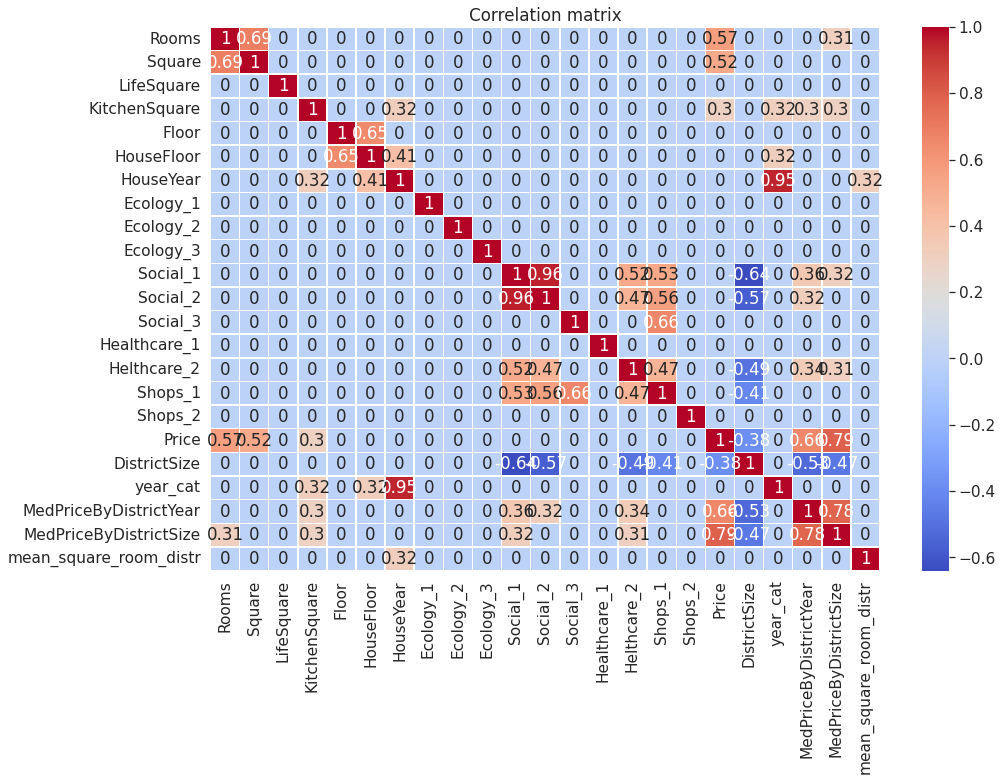

In [2266]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

<function matplotlib.pyplot.show>

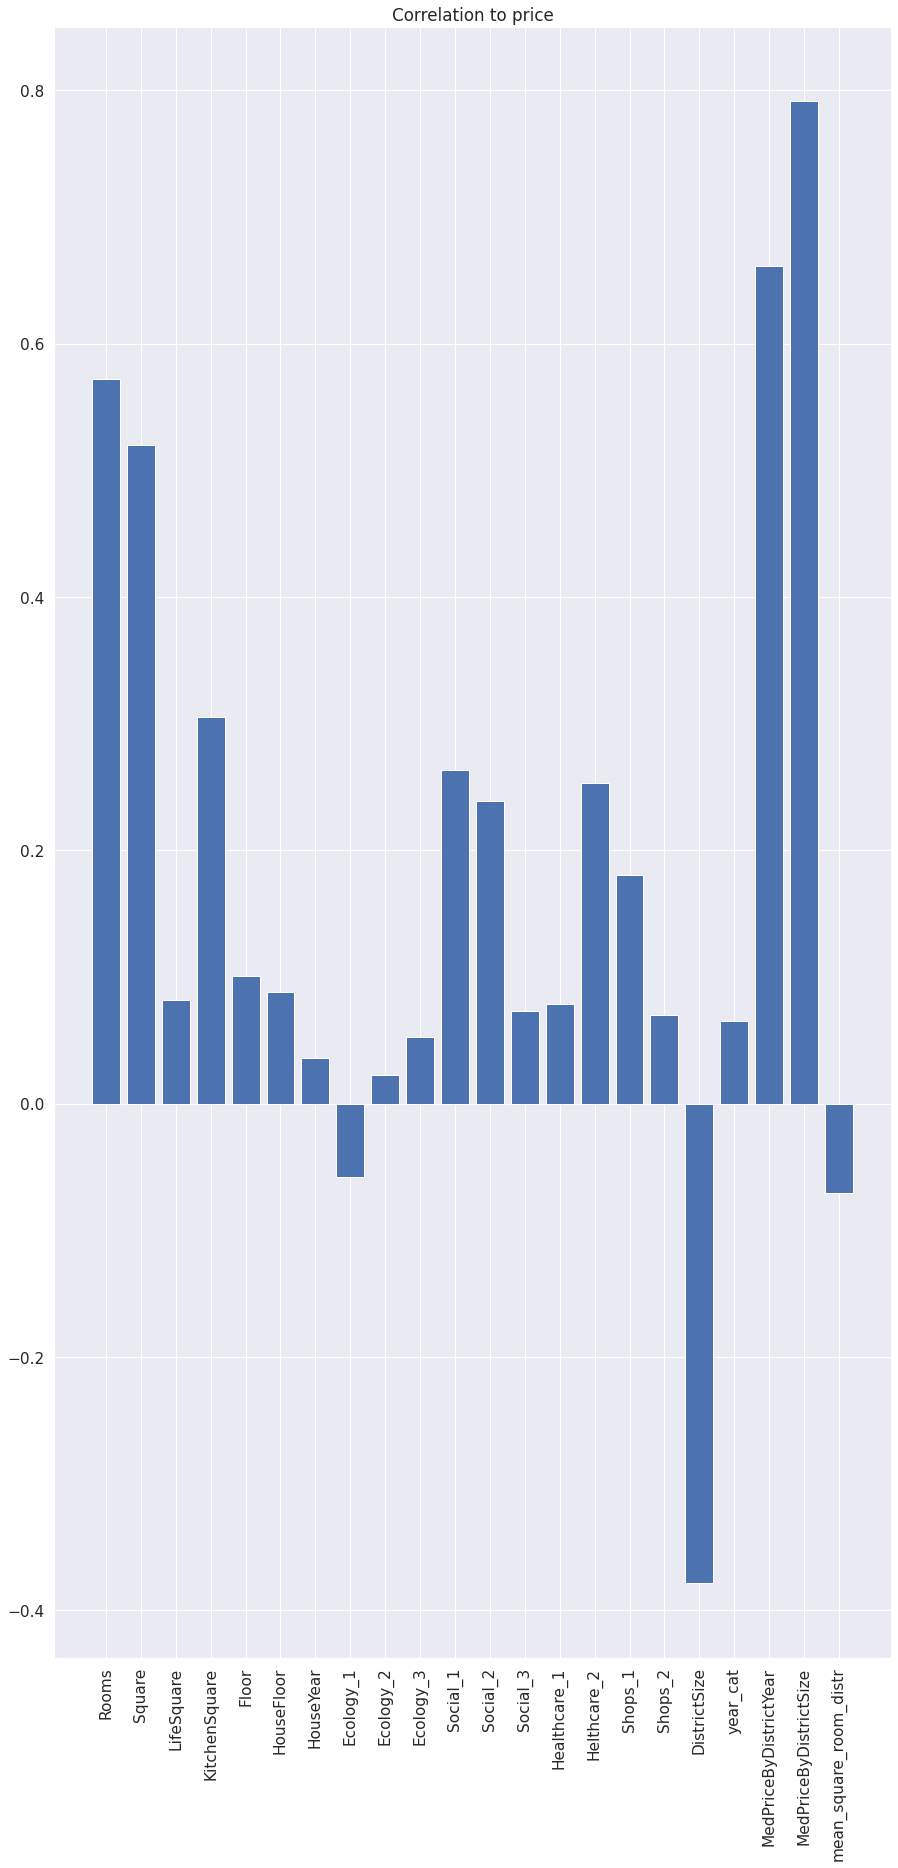

In [2267]:
corrmat=train_df.loc[:,train_df.columns!='Price'].corrwith(train_df['Price'].abs().sort_values(ascending=False)[1:])
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to price')
plt.xticks(rotation='vertical')
plt.show

In [2268]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        #self.DistrictId_counts = None
        self.med_price_by_district = None
        self.binary_to_numbers = None
        self.binary_to_numbers2 = None
        self.room_by_district = None
        self.med_price_by_district_year = None
        self.house_year_max = None
        #self.floor_max = None
        self.house_year_min = None
        #self.floor_min = None
        self.med_room_by_district=None
        self.district_size = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
         # Binary features
        self.binary_to_numbers = {'A': 1, 'B': 2}
        self.binary_to_numbers2 = {'A': 2, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

        X = X.merge(self.district_size, on='DistrictId', how='left')
                
        # Target encoding
        ## District, HouseYear
        df = X.copy()
        
        
        if y is not None:
          df['Price'] = y.values
          df['DistrictSize'] = X['DistrictSize']
          #df = df.merge(self.district_size, on='DistrictId', how='left')
          self.med_price_by_district = df.groupby(['DistrictSize', 'HouseYear'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrictSize'})
            
          self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrictSize'].median()
            
        ## Rooms, DistrictId, Square
        if y is not None:
          df['Price'] = y.values
          self.room_by_district=df.groupby(['DistrictId','HouseYear'], as_index=False).agg({'Rooms':'sum', 'Square':'sum'}).rename(columns={'Rooms':'sum_room_dr', 'Square':'sum_square_dr'})
          self.room_by_district['mean_square_room_distr']=self.room_by_district['sum_square_dr']/self.room_by_district['sum_room_dr']
          #self.rooom_by_district.drop(['sum_square_dr','sum_room_dr'], axis=1, inplace=True)                                       
          self.med_room_by_district = self.room_by_district['mean_square_room_distr'].median()
        ## District, HouseYear
        df = X.copy()
        
        
        if y is not None:
          df['Price'] = y.values
          self.house_year_max = df['HouseYear'].max()
          self.house_year_min = df['HouseYear'].min()
          df = self.year_to_cat(df)
          self.med_price_by_district_year = df.groupby(['year_cat', 'DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrictYear'})
            
          self.med_price_by_district_year_median = self.med_price_by_district_year.median()

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers2)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        #X['new_district'] = 0
        #X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        #X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X = self.year_to_cat(X)        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictSize','HouseYear'], how='left')
            X['MedPriceByDistrictSize'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_district_year is not None:
            X = X.merge(self.med_price_by_district_year, on=['year_cat','DistrictId'], how='left')
            X['MedPriceByDistrictYear'].fillna(self.med_price_by_district_year_median, inplace=True) 
        if self.room_by_district is not None:
            X = X.merge(self.room_by_district, on=['DistrictId', 'HouseYear'], how='left')
            X['mean_square_room_distr'].fillna(self.med_room_by_district, inplace=True)

        
        return X
    
    #def floor_to_cat(self, X):
        #bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        #X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        #X['floor_cat'].fillna(-1, inplace=True)
        #return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [2269]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'year_cat',
 'MedPriceByDistrictYear',
 'MedPriceByDistrictSize',
 'mean_square_room_distr']

Отберем признаки для построения моделей

In [2270]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Healthcare_1', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'year_cat']
target='Price'

Разобьем выборку на train и test

In [2271]:
train_df=pd.read_csv('/content/drive/MyDrive/Тренировочные данные/Project data housing Msk/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Тренировочные данные/Project data housing Msk/test.csv')
X = train_df.drop(columns=target)
y = train_df[target]

In [2272]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=41)

In [2273]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6500, 19), (3500, 19), (5000, 19))

In [2274]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6500, 26), (3500, 26), (5000, 26))

In [2275]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [2276]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**Построение моделей**

***Линейная регрессия***

Проведем стандартизацию признаков

In [2277]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#test_df= scaler.transform(test_df)



In [2278]:
#X_train[feature_names + new_feature_names].to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, encoding='utf-8')
#X_valid[feature_names + new_feature_names].to_csv(PREPARED_DATASET_PATH_Valid, index=False, encoding='utf-8')

In [2279]:
lr_model=LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

Train R2:	0.545
Test R2:	0.277


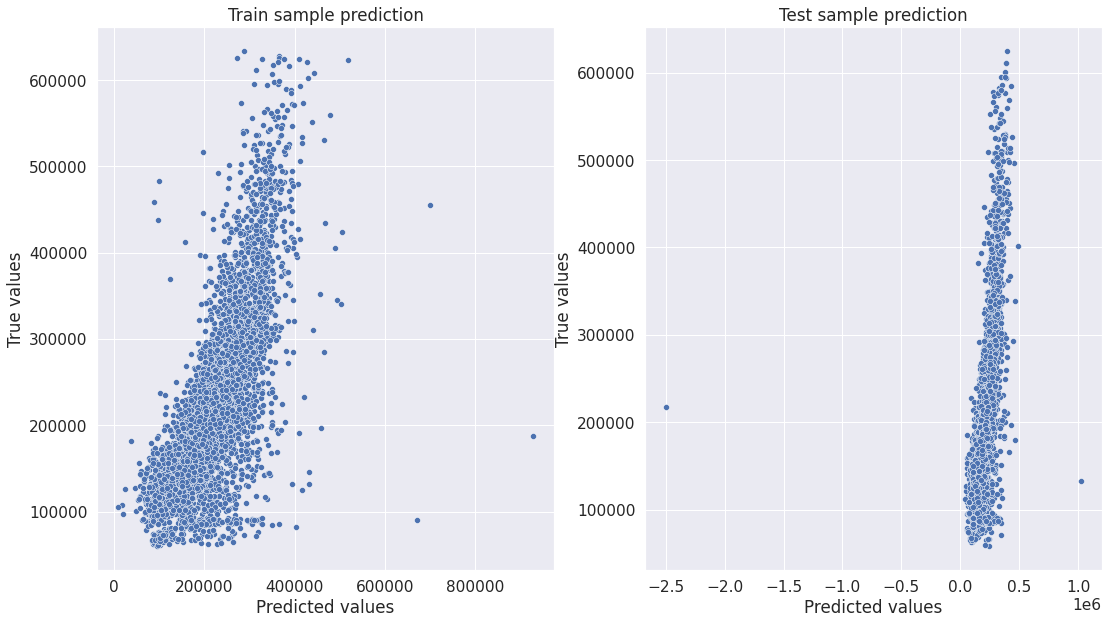

In [2280]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [2281]:
cv_score = cross_val_score(lr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.51441154, 0.55589286, 0.53836208])

In [2282]:
cv_score.mean()

0.5362221573220397

***RandomForest model***

In [2283]:
rf_model=RandomForestRegressor(criterion='mse',
                                 max_depth=20,  
                                 min_samples_leaf=30,
                                 random_state=42, 
                                 n_estimators=100)
rf_model.fit(X_train,y_train)


RandomForestRegressor(criterion='mse', max_depth=20, min_samples_leaf=30,
                      random_state=42)

Train R2:	0.734
Test R2:	0.696


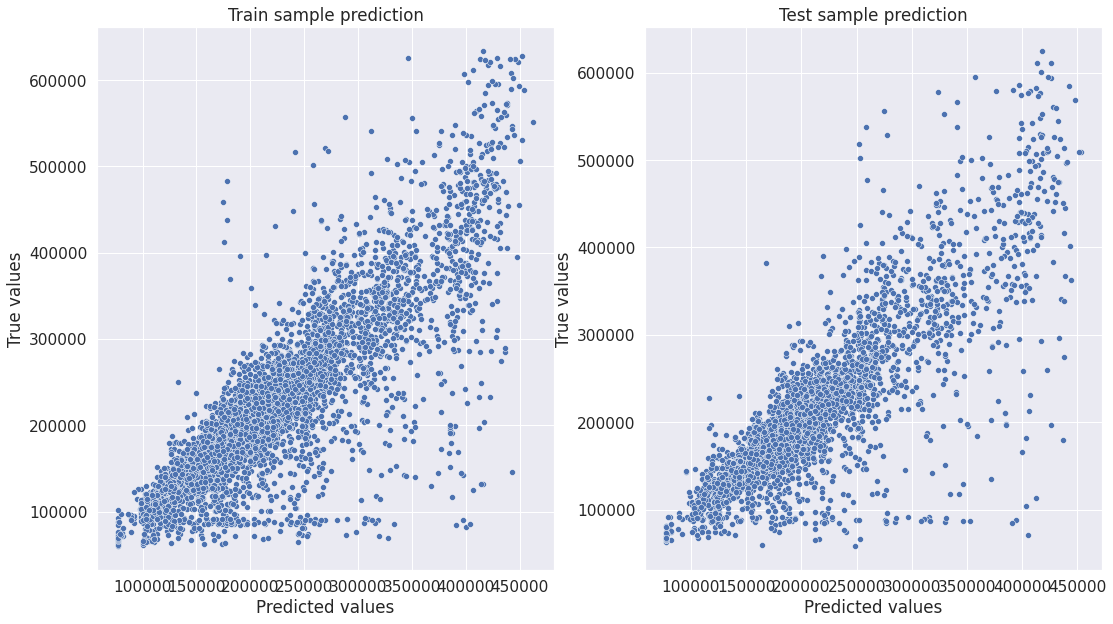

In [2284]:
y_train_preds=rf_model.predict(X_train)
y_test_preds=rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [2285]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.67785218, 0.69806447, 0.66163076])

In [2286]:
cv_score.mean()

0.6791824681434281

***Gradient Boosting***

In [2287]:
#params = {'n_estimators':[50, 100, 200, 400], 
          #'max_depth':[3, 5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
                  #scoring='r2', 
                  #cv=KFold(n_splits=3,   
                           #random_state=21, 
                           #shuffle=True),
                  #n_jobs=-1
                  #)
#gs.fit(X_train, y_train)

In [2288]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

Train R2:	0.905
Test R2:	0.733


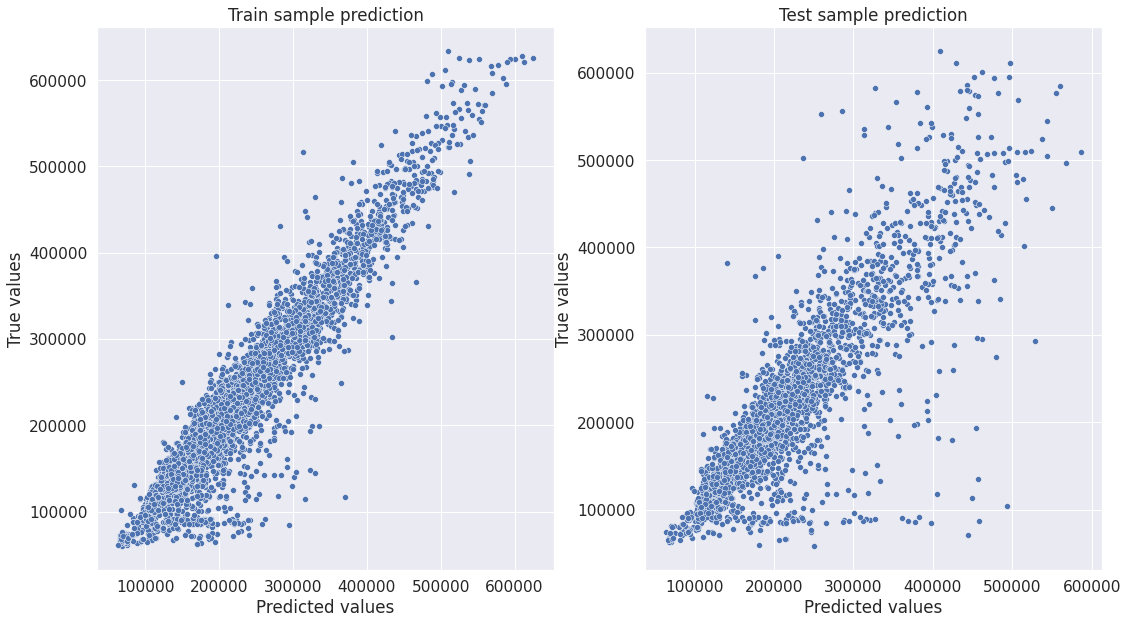

In [2289]:
y_train_preds=gb_model.predict(X_train)
y_test_preds=gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [2290]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73535647, 0.73476726, 0.71183351])

In [2291]:
cv_score.mean()

0.7273190791075783

***LGBM model***

In [2292]:
lgbm_model=LGBMRegressor(max_bin=110, num_levels=4, n_estimators=4000, learning_rate=0.01)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_levels=4)

Train R2:	0.952
Test R2:	0.732


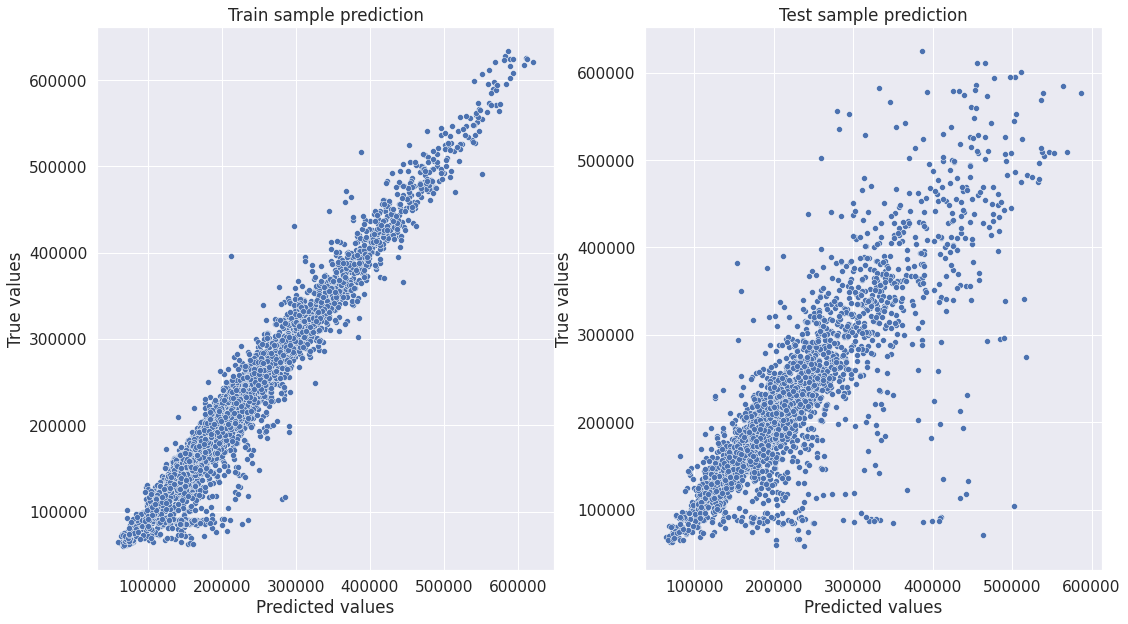

In [2293]:
y_train_preds=lgbm_model.predict(X_train)
y_test_preds=lgbm_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [2294]:
cv_score = cross_val_score(lgbm_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73434068, 0.73113843, 0.71158234])

In [2295]:
cv_score.mean()

0.7256871518012823

In [2297]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.473955
17,DistrictSize,0.243400
12,Social_3,0.052421
7,Ecology_1,0.031657
6,HouseYear,0.029319
11,Social_2,0.028861
2,LifeSquare,0.026003
10,Social_1,0.021327
5,HouseFloor,0.020382
14,Healthcare_1,0.015790


самое большое среднее значение по кросвалидации получилось по модели Gradient Boosting, поэтому ее выбираем как итоговый вариант модели

**Прогнозирование на тесте**

In [2298]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Healthcare_1,Shops_1,Shops_2,DistrictSize,year_cat
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,2,1,24,4378,0,1,1036.0,1,2,75.0,2.0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,1,2,629,1,0,1024.5,0,1,153.0,5.0
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,2,1,9,1892,0,0,1013.0,1,2,532.0,2.0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,1,2,475,0,0,1001.5,0,2,374.0,2.0
4,1.0,53.837056,45.837056,5.0,8,17.0,1977,0.309479,2,1,35,7715,4,0,990.0,6,2,78.0,2.0


In [2299]:
submit = pd.read_csv('/content/drive/MyDrive/Тренировочные данные/Project data housing Msk/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [2300]:
predictions = gb_model.predict(test_df)
predictions

array([158815.88681793, 122041.74433663, 148267.44270788, ...,
       143521.74767955, 194708.54549229, 277091.1432506 ])

In [2301]:
submit['Price']=predictions
submit.head()

,Id,Price
0,4567,158815.886818
1,5925,122041.744337
2,960,148267.442708
3,3848,132504.032436
4,746,213117.960464


In [2302]:
submit.to_csv('gb_submit.csv', index=False)
